### Load Modules

In [1]:
# Restart the kernel
import os
import dill as pickle
notebook_dir = os.getcwd()

current_dir ='../../../../../'
os.chdir(current_dir)

from src.codes.basic import *
from src.codes.utils.fem_utils_StrucMech import *
from src.codes.utils.plot_files.plot_utils import OneDPlot as plot
from src.codes.utils.plot_files.plot_utils import data_stats
from src.codes.utils.rom_utils import *
from src.codes.utils.dynamical_systems import *
import time as time

from src.codes.prob_classes.structural_mechanics.base_class_struc_mech_continuous_vibration import ROM_simulation_non_p
from src.codes.algorithms.ecsw import ecsw_red

# from importlib import reload

### Load data

In [2]:
filename_dataC = './examples/structural_mechanics/Transverse/continuous_vibrations/oneD_beam/data/DataClass_structMech_1p.dill'
with open(filename_dataC, 'rb') as f:
    Data_cls = pickle.load(f)

In [3]:
# load required variables from data
FOS = Data_cls.FOS
d = FOS.data
mask_dv = np.append(d.mask, d.mask)
param_list = np.asarray(Data_cls.param_list)
NLS = np.asarray(Data_cls.NL_solutions)
K_mus = Data_cls.K_mus
C_mus = Data_cls.C_mus
t = Data_cls.t
q_mus = Data_cls.q_mus

# train_mask, test_mask = Data_cls.train_mask, Data_cls.test_mask 

_,N_snap = np.shape(NLS[0])
print(N_snap)

5001


## ECSW Hyper-reduction

### Train-Test split

In [4]:
Snap_sel=100
train_mask, _ = train_test_split(N_snap,N_sel=Snap_sel)

### Data-processing

In [5]:
NLS_wd = NLS[0][mask_dv]
NLS_wd_train = NLS_wd[:,train_mask]

dim_da = int(NLS_wd_train.shape[0]/2) # train only on disp_vel
NLS_wd_train_da = NLS_wd_train[:dim_da]


### Mean Subtraction

In [6]:
NLS_train_mean = np.mean(NLS_wd_train_da,axis=1)
NLS_train_ms = NLS_wd_train_da - NLS_train_mean.reshape(-1,1)

### Plot snapshots

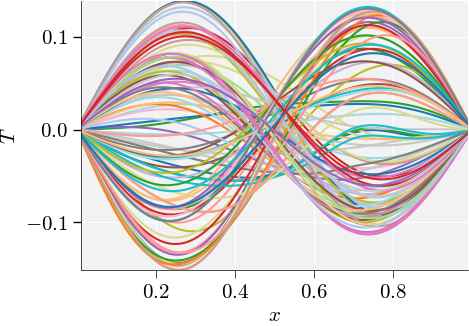

In [7]:
fig, ax = plt.subplots(figsize=(5,3.5))

for i in range(Snap_sel):
    Plot = plot(d.xi[0][1:-1], NLS_train_ms[1:-1:2,i], ax=ax)
    Plot.line_()

plt.show()


#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

Number of modes selected: 6


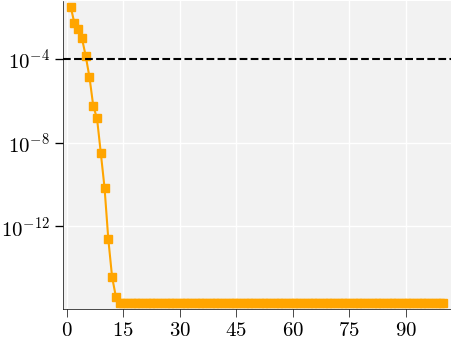

In [8]:
plt.rcParams['figure.dpi'] = 100
n_sel, U = svd_mode_selector(NLS_train_ms.T, tolerance=1e-4,modes=True)
V_sel = U[:, :n_sel]

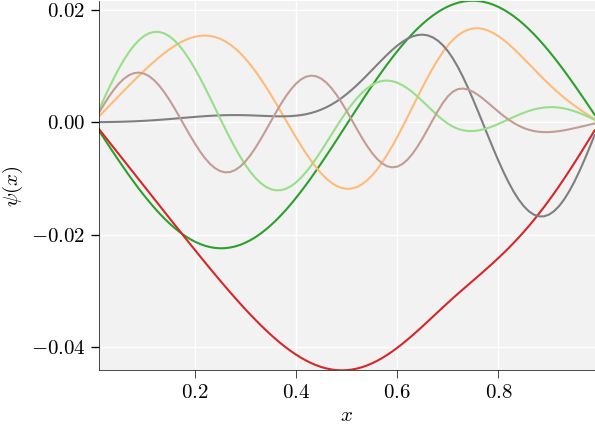

In [9]:
fig, ax = plt.subplots()

for i in range(n_sel):
    Plot = plot(d.xi[0][1:-1], V_sel[1:-1:2,i], ax=ax)
    Plot.line_()

Plot.ax.set_xlabel('$x$')
Plot.ax.set_ylabel('$\psi(x)$')

plt.show()

### Step 2: Perform NNLS for ECSW

In [10]:
_,N_snap_train = np.shape(NLS_wd_train_da)
tol = 1e-4

In [11]:
NLS_train_mean.shape

(200,)

In [12]:
tic_h_setup_b = time.time()


data = {'K_mus':K_mus,'q_mus':q_mus, 'C_mus':C_mus}
xi, residual = ecsw_red(d, V_sel, d.Le, data, n_sel, N_snap_train, NLS_wd_train.T, NLS_train_mean, Data_cls.FOS.residual_func, tol=tol,SS=True)


toc_h_setup_b = time.time()

norm of rhs: 1059.9029579524813


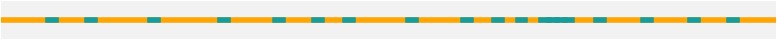

Fraction of total elements active in the ROM: 19.0%
residual=2.996154169908339e-07


In [13]:
plot(np.arange(d.ncells[0]), xi, ax="").element_()
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")
print(f"{residual=}")


### ROM Simulation

In [14]:
ROM_h = ROM_simulation_non_p(Data_cls, V_sel, xi) #, N_rom_snap=1)
ROM_h.run_simulation()

c:\Users\suparnob\AppData\Local\anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:602: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
c:\Users\suparnob\OneDrive - Texas A&M University\Academic\TAMU_MATERIALS\POSTDOC\HYPERREDUCTION\SUPARNO\HYPERREDUCTION__TAMIDS\pyHyperRom\src\codes\utils\fem_utils_StrucMech.py:385: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  MK_inv = spalg.spsolve(M, K).toarray()
c:\Users\suparnob\OneDrive - Texas A&M University\Academic\TAMU_MATERIALS\POSTDOC\HYPERREDUCTION\SUPARNO\HYPERREDUCTION__TAMIDS\pyHyperRom\src\codes\utils\fem_utils_StrucMech.py:386: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  MC_inv = spalg.spsolve(M, C).toarray()


In [15]:
ROM = ROM_simulation_non_p(Data_cls, V_sel)#, xi=xi)#, N_rom_snap=1)
ROM.run_simulation()

### Performance Statistics

In [16]:
NLS_rom_h = np.asarray(ROM_h.NL_solutions_rom)
ROM_speed_up_h = ROM_h.speed_up
print(ROM_speed_up_h)

[7.7293759325219416]


In [17]:
NLS_rom = np.asarray(ROM.NL_solutions_rom)
ROM_speed_up = ROM.speed_up
print(ROM_speed_up)

[3.4403231359389386]


In [18]:
# ROM_SOL = ROM.NL_solutions_rom[0]
# fig, ax = plt.subplots(figsize=(5,3.5))

# for i in range(Snap_sel*10):
#     Plot = plot(d.xi[0], ROM_SOL[0][::2,i], ax=ax)
#     Plot.line_()

# plt.show()

Relative error in displacement: 0.17799877666854613
Relative error in velocity: 1.7039326220788469


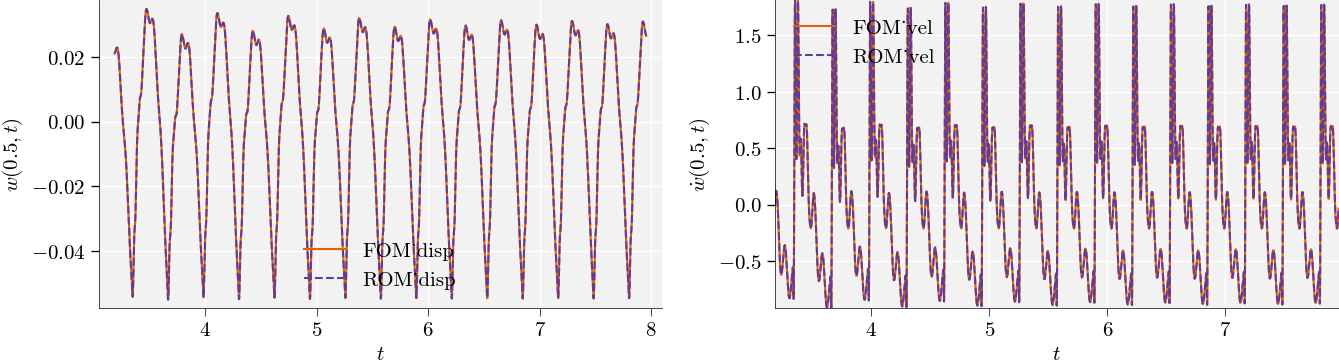

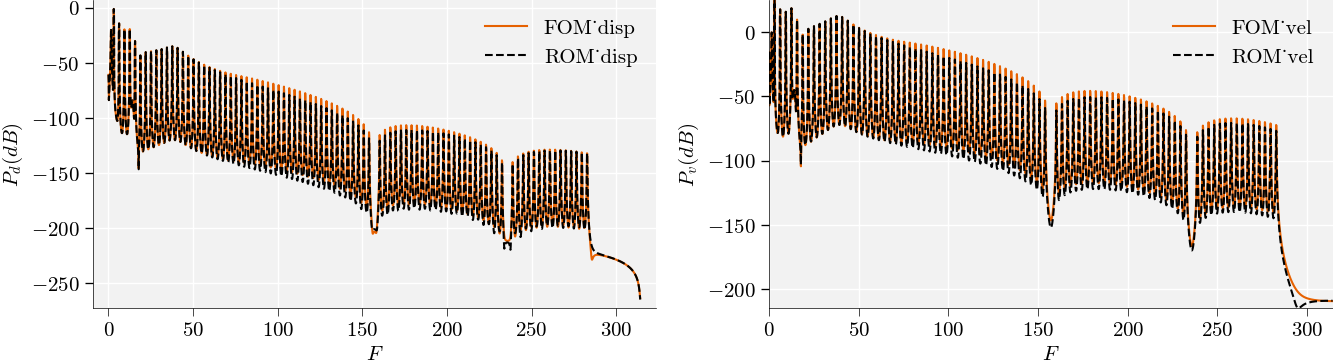

In [19]:
compare_models(NLS[0], ROM_h.NL_solutions_rom[0], t)

Relative error in displacement: 0.1778079006468773
Relative error in velocity: 1.7030055872373686


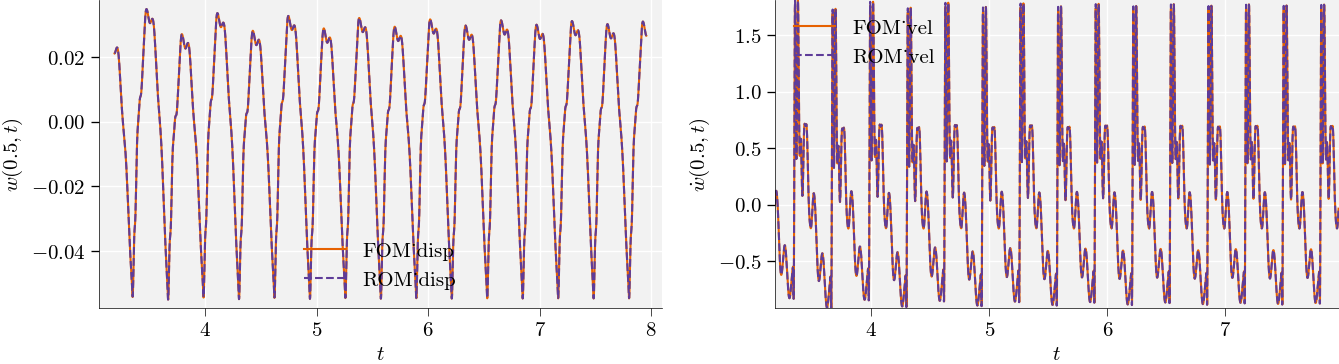

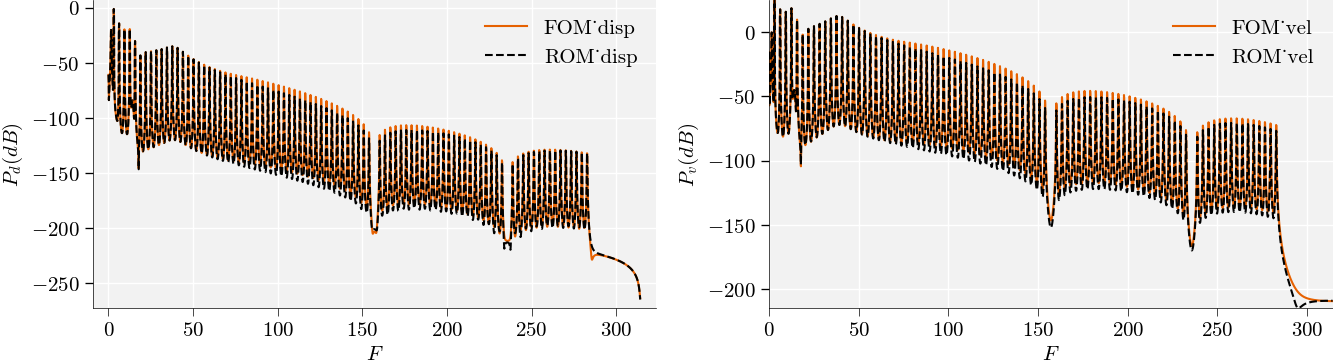

In [20]:
compare_models(NLS[0], ROM.NL_solutions_rom[0], t)